In [2]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

#### Load the data

In [3]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [4]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Load the train, validation, test split from file

In [5]:
loader = np.load('pretrained/cora_ml/split.npy',allow_pickle=True).item()

In [6]:
train_ones = loader['train_ones']
val_ones = loader['val_ones']
val_zeros = loader['val_zeros']
test_ones = loader['test_ones']
test_zeros = loader['test_zeros']

In [7]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [8]:
rw_len = 16
batch_size = 128

In [9]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### Create our NetGAN model

In [10]:
print(tf.__version__)
print(tf.test.is_gpu_available())

1.15.0


2025-06-11 09:08:18.966370: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2025-06-11 09:08:18.993226: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2500000000 Hz
2025-06-11 09:08:18.997550: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4fd6cf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-06-11 09:08:18.997565: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-06-11 09:08:18.999993: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


True


2025-06-11 09:08:19.171779: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4f406d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-11 09:08:19.171826: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-06-11 09:08:19.173080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:1b:00.0
2025-06-11 09:08:19.173684: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2025-06-11 09:08:19.176723: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2025-06-11 09:08:19.179510: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10

In [13]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()

netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=32, W_down_generator_size=128,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, temperature_decay=0.99998, learning_rate=0.0003, legacy_generator=True)

2025-06-11 09:16:47.891292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:1b:00.0
2025-06-11 09:16:47.891377: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2025-06-11 09:16:47.891387: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2025-06-11 09:16:47.891400: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2025-06-11 09:16:47.891410: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2025-06-11 09:16:47.891419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2025-06-11 09:16:47.891428: I tensorflow/stream_e

#### Load pretrained model

In [14]:
saver = tf.train.Saver()
saver.restore(netgan.session, "pretrained/cora_ml/pretrained_gen.ckpt")


INFO:tensorflow:Restoring parameters from pretrained/cora_ml/pretrained_gen.ckpt


#### Generate random walks on the trained model

In [15]:
sample_many = netgan.generate_discrete(10000, reuse=True, legacy=True)

In [16]:
samples = []

In [17]:
for _ in range(60):
    if (_+1) % 500 == 0:
        print(_+1)
    samples.append(sample_many.eval({netgan.tau: 0.5}))

2025-06-11 09:17:00.139314: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


#### Assemble score matrix from the random walks

In [18]:
rws = np.array(samples).reshape([-1, rw_len])
scores_matrix = utils.score_matrix_from_random_walks(rws, _N).tocsr()

#### Compute graph statistics

In [19]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))

In [20]:
A_select = train_graph

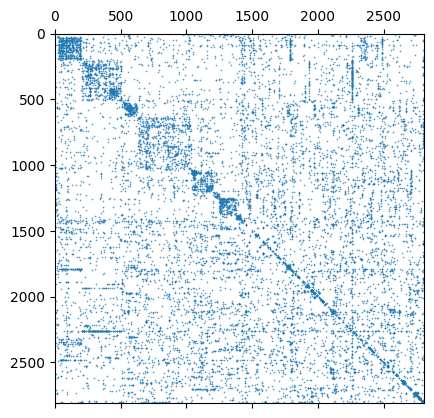

In [21]:
sampled_graph = utils.graph_from_scores(scores_matrix, A_select.sum())
plt.spy(sampled_graph, markersize=.2)
plt.show()

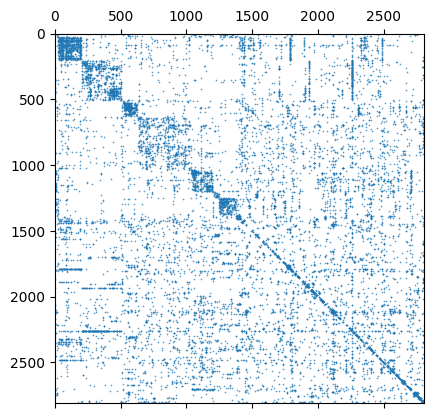

In [22]:
plt.spy(A_select, markersize=.2)
plt.show()

In [23]:
utils.edge_overlap(A_select.toarray(), sampled_graph)/A_select.sum()

0.5142267433289105

In [24]:
utils.compute_graph_statistics(sampled_graph)

{'d_max': 216.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2810,
 'wedge_count': 81845.0,
 'claw_count': 2134287.0,
 'triangle_count': 1474,
 'square_count': 81,
 'power_law_exp': 1.7891457644356703,
 'gini': 0.41803776764498646,
 'rel_edge_distr_entropy': 0.9549409016370461,
 'assortativity': -0.07260086526522781,
 'clustering_coefficient': 0.002071886302076525,
 'n_components': 1,
 'cpl': 5.155596715691429}

In [25]:
utils.compute_graph_statistics(A_select.toarray())

{'d_max': 240.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2810,
 'wedge_count': 101872.0,
 'claw_count': 3094240.0,
 'triangle_count': 2814,
 'square_count': 517,
 'power_law_exp': 1.85595899191131,
 'gini': 0.48239580529720794,
 'rel_edge_distr_entropy': 0.9407067745192429,
 'assortativity': -0.07543032480414194,
 'clustering_coefficient': 0.0027282951548684006,
 'n_components': 1,
 'cpl': 5.60937302442961}